<a href="https://colab.research.google.com/github/sesael/flask-render-integration/blob/main/mba_admission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
!pip install flask

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

import joblib

from flask import Flask

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"edgardogomez","key":"1a9e6201e95c6ca442440b84c1d3be5d"}'}

In [5]:
!kaggle datasets download -d taweilo/mba-admission-dataset

Dataset URL: https://www.kaggle.com/datasets/taweilo/mba-admission-dataset
License(s): apache-2.0
  0% 0.00/54.9k [00:00<?, ?B/s]
100% 54.9k/54.9k [00:00<00:00, 50.2MB/s]


In [6]:
!unzip mba-admission-dataset.zip

Archive:  mba-admission-dataset.zip
  inflating: MBA.csv                 


In [7]:
df = pd.read_csv("/content/MBA.csv")

In [8]:
df.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   application_id  6194 non-null   int64  
 1   gender          6194 non-null   object 
 2   international   6194 non-null   bool   
 3   gpa             6194 non-null   float64
 4   major           6194 non-null   object 
 5   race            4352 non-null   object 
 6   gmat            6194 non-null   float64
 7   work_exp        6194 non-null   float64
 8   work_industry   6194 non-null   object 
 9   admission       1000 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 441.7+ KB


We can see there is a los of null values in the race and admission column.

According to the dataset author, any nan values in the race column, meant the student was internationa.

In the same way, a nan value in admission meant a denied admission.

Lets replace those values

In [10]:
df["race"].fillna("International", inplace=True)
df["admission"].fillna("Denied", inplace=True)

<ipython-input-10-f7d0fd4e15ea>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["race"].fillna("International", inplace=True)
<ipython-input-10-f7d0fd4e15ea>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [11]:
df["admission"].value_counts()

,count
admission,
Denied,5194
Admit,900
Waitlist,100


In [12]:
df = df.drop("application_id", axis = 1)
df_num = df.select_dtypes(include=['int64', 'float64'])
df_cat = df.select_dtypes(include=['object',"bool"])

<Axes: >

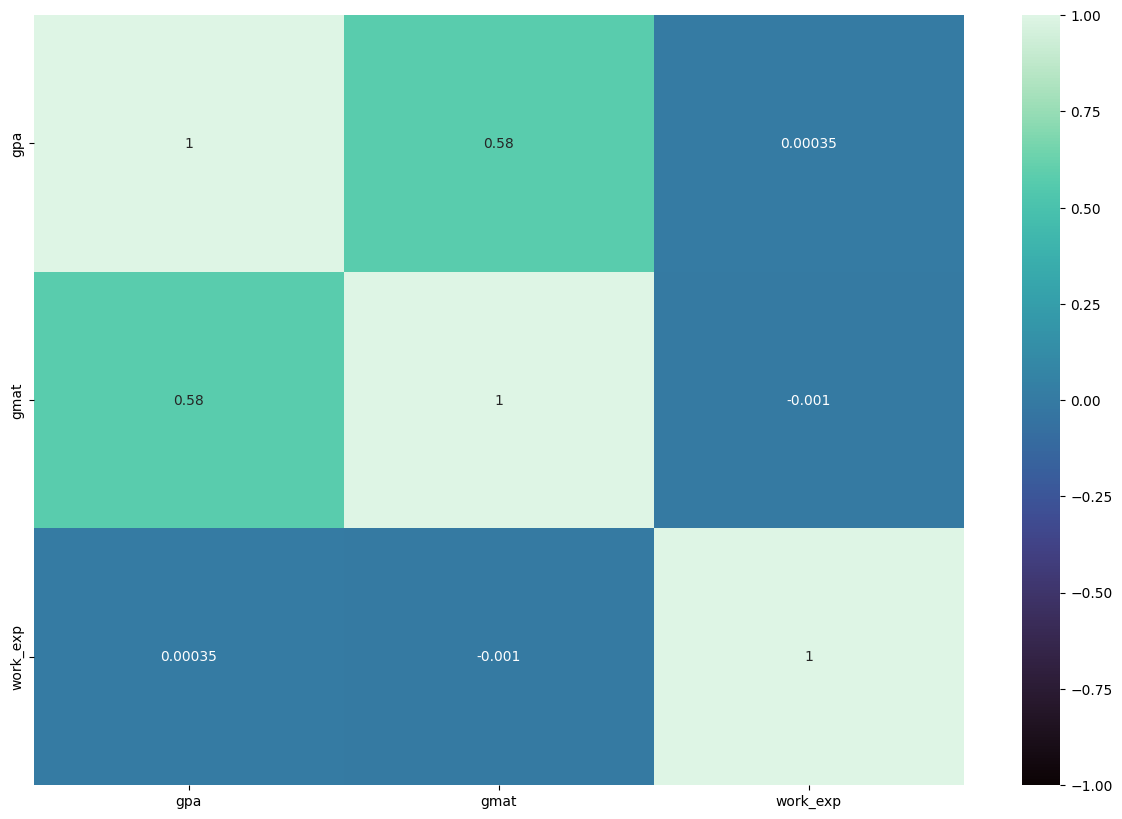

In [13]:
plt.subplots(figsize=(15,10))
sns.heatmap(df_num.corr(), annot=True, vmin=-1, vmax = 1, cmap="mako")

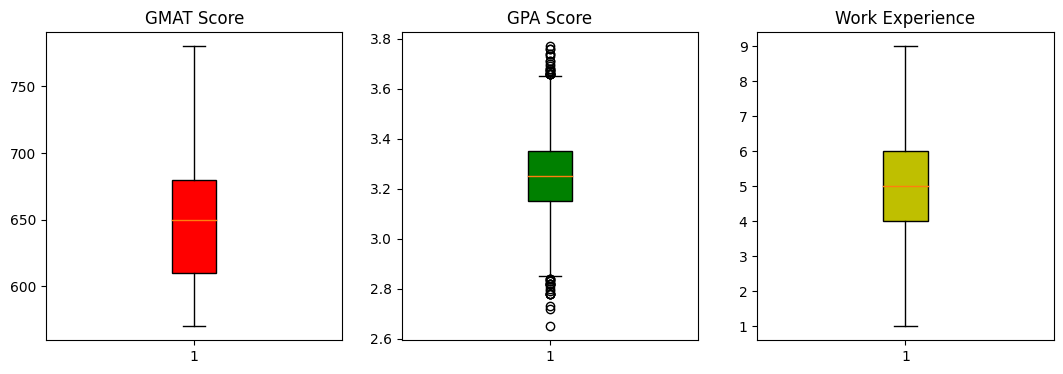

In [14]:
fig, ax = plt.subplots(1,3, figsize=(13,4))

ax[0].boxplot(df["gmat"], patch_artist=True, boxprops=dict(facecolor="r"))
ax[0].set_title("GMAT Score")
ax[1].boxplot(df["gpa"], patch_artist=True, boxprops=dict(facecolor="g"))
ax[1].set_title("GPA Score")
ax[2].boxplot(df["work_exp"], patch_artist=True, boxprops=dict(facecolor="y"))
ax[2].set_title("Work Experience")

fig.show()

In [15]:
fig = make_subplots(rows=2, cols=3)

rows = 1
cols = 1

for col in df_cat.columns:
    fig.add_trace(
          go.Histogram(x=df[col], name=col),
          row=rows, col=cols)
    if cols < 3:
      cols += 1
    else:
      cols = 1
      rows += 1

fig.update_traces(showlegend = True)
fig.update_layout(height=800, width=1500, title_text="Histogram", showlegend=True)

fig.show()

###Data Training

Lets begin the label enconding

In [19]:
label_encoders = {}

df_encoded = pd.DataFrame()

for col in list(df_cat.columns):
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [24]:
#Saving the label encoders
for col, le in label_encoders.items():
    joblib.dump(le, f'{col}_encoder.joblib')

In [25]:
df_encoded_with_num = df_num.join(df_encoded)
df_encoded_with_num.head()

,gpa,gmat,work_exp,gender,international,major,race,work_industry,admission
0,3.30,620.0,3.0,0,0,0,0,3,0
1,3.28,680.0,5.0,1,0,1,1,6,1
2,3.30,710.0,5.0,0,1,0,3,13,0
3,3.47,690.0,6.0,1,0,2,1,13,1
4,3.35,590.0,5.0,1,0,2,2,1,1


In [29]:
#Stablishing X and Y (target)
X = df_encoded_with_num.drop("admission", axis=1)
y = df_encoded_with_num["admission"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
#Initiating XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

#Training the XGB model
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[12:52:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [31]:
#Predicting the model
y_pred = xgb_model.predict(X_test)

In [32]:
report = classification_report(y_test, y_pred, target_names=['Admit', 'Denied', 'Waitlist'])
print(report)

              precision    recall  f1-score   support

       Admit       0.45      0.23      0.31       196
      Denied       0.85      0.95      0.90      1025
    Waitlist       0.00      0.00      0.00        18

    accuracy                           0.82      1239
   macro avg       0.43      0.39      0.40      1239
weighted avg       0.78      0.82      0.79      1239



Since the f1 score is very low for "Admit", lets do some hyperparameter tuning to make it better.

In [33]:
#Defining the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'scale_pos_weight': [1, 2, 5, 10]
}

In [34]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                       n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

In [36]:
xgb_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[13:03:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "bootstrap", "class_weight", "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.




RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'max_depth': [10, 20, 30, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=42, verbose=2)

In [37]:
#Getting the best model from the search
best_xgb_model = xgb_random_search.best_estimator_

#Predicting the model
y_pred_best_xgb = best_xgb_model.predict(X_test)

In [39]:
#Getting a classification report
best_xgb_report = classification_report(y_test, y_pred_best_xgb, target_names=["Admit", "Deny", "Watilist"])
print(best_xgb_report)

              precision    recall  f1-score   support

       Admit       0.41      0.28      0.33       196
        Deny       0.86      0.92      0.89      1025
    Watilist       0.00      0.00      0.00        18

    accuracy                           0.81      1239
   macro avg       0.42      0.40      0.41      1239
weighted avg       0.77      0.81      0.79      1239



The model seems to have gotten a bit better for the "Admit" group. Lets save it and use it for a prediction on denial.


In [40]:
joblib.dump(best_xgb_model, 'xgb_model.joblib')

['xgb_model.joblib']